In [1]:
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm

train = pd.read_pickle(Path('../data/interim/train.pkl'))
valid = pd.read_pickle(Path('../data/interim/valid.pkl'))
test = pd.read_pickle(Path('../data/interim/test.pkl'))

Reviews contain html tags, so let's remove them.

In [2]:
from bs4 import BeautifulSoup

tqdm.pandas()
train['review'] = train['review'].progress_map(lambda s: BeautifulSoup(s).get_text())
valid['review'] = valid['review'].progress_map(lambda s: BeautifulSoup(s).get_text())
test['review'] = test['review'].progress_map(lambda s: BeautifulSoup(s).get_text())

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

### Dataset balance

Let's look what is a distribution of sentiments in our dataset.

Train dataset:

In [3]:
train['sentiment'].value_counts(normalize=True)

positive    0.50035
negative    0.49965
Name: sentiment, dtype: float64

Test dataset:

In [4]:
test['sentiment'].value_counts(normalize=True)

negative    0.5
positive    0.5
Name: sentiment, dtype: float64

As we see, both train and test datasets are balanced, so the baseline classifier has accuracy 50%.

## Bag-of-Words models

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.7,
    min_df=100,
    stop_words='english'
)

X_train = vectorizer.fit_transform(train['review'])
X_valid = vectorizer.transform(valid['review'])

In [6]:
Y_train = train['sentiment'] == 'positive'
Y_valid = valid['sentiment'] == 'positive'

### Linear model

First fit logistic regression as a baseline.

In [7]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

Let's see the accuracy of the model on train dataset

In [8]:
model.score(X_train, Y_train)

0.90565

And on valid dataset

In [9]:
model.score(X_valid, Y_valid)

0.8742

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


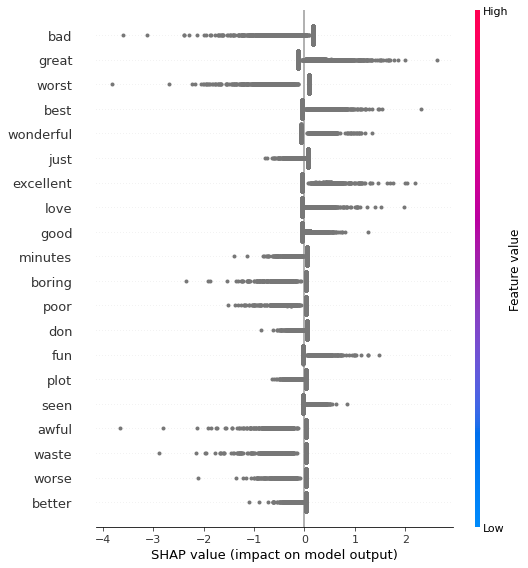

In [10]:
import shap

explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_valid)

shap.summary_plot(shap_values, X_valid, feature_names=vectorizer.get_feature_names())

### Tree-based model

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_jobs=-1,
    max_depth=50
)
model.fit(X_train, Y_train);

In [12]:
model.score(X_train, Y_train)

0.9895

In [13]:
model.score(X_valid, Y_valid)

0.8354

### FastText

[FastText](https://fasttext.cc/docs/en/crawl-vectors.html) is a library that utilizes embeddings of word n-grams. The
classification of text is performed by ([1]):

1. calculating embeddings for each n-gram,
1. calculating embedding of a document as a mean of the embeddings of n-grams that appear in the document,
1. using the calculated document's embedding as features of linear classifier.

So FastText is, basically, linear model over the embeddings of the n-grams. It's worth to notice that
FastText is really fast.

In [27]:
import fasttext
from tempfile import NamedTemporaryFile
import csv

train['sentiment'] = '__label__' + train['sentiment'].astype('str')
valid['sentiment'] = '__label__' + valid['sentiment'].astype('str')

with NamedTemporaryFile() as f:
    train[['sentiment', 'review']].to_csv(
        f.name,
        index=False,
        sep=' ',
        header=None,
        quoting=csv.QUOTE_NONE,
        quotechar="",
        escapechar=" "
    )
    model = fasttext.train_supervised(f.name, epoch=10)
    print(model.test(f.name))

(20000, 0.9361, 0.9361)


In [28]:
with NamedTemporaryFile() as f:
    valid[['sentiment', 'review']].to_csv(
        f.name,
        index=False,
        sep=' ',
        header=None,
        quoting=csv.QUOTE_NONE,
        quotechar="",
        escapechar=" "
    )
    print(model.test(f.name))

(5000, 0.8744, 0.8744)


[1] Bag of Tricks for Efficient Text Classification, A. Joulin et al, https://www.aclweb.org/anthology/E17-2068.pdf

